In [34]:
#import essential libraries for apply arima model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot


In [35]:
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline


In [36]:
# import os ,auto arima library
from pmdarima.arima import auto_arima
import os


In [37]:
DATA_FOLDER = r'D:\project\BA\final\data'

In [56]:
#build class ARIMA with those function : init, load data, decompose , plot acf-pacf, apply stationary ,  predict, evaluate, report MSE and RMSE, plot
class ARIMA_Model:
    def __init__(self, data_path):
        self.data_path = data_path
        self.test_size = 0
        self.train_size = 0
        self.val_size = 0
        self.test_valid_size = 0
        self.df = None
        self.test_data = None
        self.train_data = None
        self.val_data = None
        self.p_value = 0
        self.d_value = 0
        self.q_value = 0
        self.step_forecast = 0
        
        return None
    
    def split_size(self, test_size, val_size):
        self.test_size = test_size 
        self.train_size = 1 - test_size -val_size
        self.val_size = val_size

        self.test_valid_size = test_size  + val_size
        return None
    
    def split_data(self,test_size, val_size):
        self.df = self.load_data()
        self.split_size(float(test_size), float(val_size))
        test_start_date = self.df.index[int(self.train_size * len(self.df))]
        test_start_pos = self.df.index.get_loc(test_start_date)
        # self.test_data = self.df.iloc[int(self.train_size*len(self.df)):]
        self.test_val_data = self.df.iloc[test_start_pos:]

        #get val_data from test_val_data
        val_start_date = self.df.index[int(self.train_size * len(self.df)) + int(self.test_size * len(self.df))]

        val_start_pos = self.df.index.get_loc(val_start_date)
     
        self.val_data = self.df.iloc[val_start_pos:]
        #get test_data from test_val_data
        self.test_data = self.df.iloc[test_start_pos:val_start_pos]

        train_end_date = self.df.index[int(self.train_size * len(self.df)) - 1]
        train_end_pos = self.df.index.get_loc(train_end_date)

        # self.train_data = self.df.iloc[:int(self.train_size*len(self.df))]
        self.train_data = self.df.iloc[:train_end_pos + 1]
        self.step_forecast = len(self.test_val_data) + 30
        return None

    def info_data(self):
        #print len of train,test,val 
        print('Dataset size', len(self.df),'\n')
        print('Train size : ',len(self.train_data))
        print('Test size : ',len(self.test_data))
        print('Valid size : ',len(self.val_data))
        return None

    def load_data(self):
        df = pd.read_csv(self.data_path)
        df['Date'] = pd.to_datetime(df['Date'])
        # df['Close'] = df['Close'].str.replace(',', '')
        # df['Close'] = df['Close'].astype(float)
        df.set_index('Date', inplace=True)
        df.sort_index(axis=0, ascending=True, inplace=True)
        return df
    
    def decompose(self, df):
        result = seasonal_decompose(df, model='multiplicative',period=90)
        fig = result.plot()
        fig.set_size_inches(16,12)
        return None
    
    def plot_acf_pacf(self,df):
        fig, ax = plt.subplots(1, 2, figsize=(16,4))
        plot_acf(x=df, ax=ax[0])
        plot_pacf(x=df, ax=ax[1])

    def stationary(self, df):
        df_diff = df.diff(periods=1)
        df_diff = df_diff[1:]
        return df_diff
    
    def adf_test(self, df):
        result = adfuller(df)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        return result[0], result[1]
    
    def auto_arima(self, df_train):  
        stepwise_fit = auto_arima(df_train, trace=True, error_action='ignore', suppress_warnings=True)
        stepwise_fit = stepwise_fit.fit(df_train)
        print(stepwise_fit.summary())
        return stepwise_fit
    
   
    def prediction(self, df_train):
        model_fit = self.auto_arima(df_train)
        predictions = model_fit.predict(n_periods=self.step_forecast)
        # get test_pred in predictions
        
        val_pred = predictions[len(self.test_data):len(predictions)-30]
        test_pred = predictions[:len(self.test_data)]
        future_predict = predictions[len(predictions)-30:]

        print('predictions size : ',len(predictions))
        print('TestPred size : ',len(test_pred))
        print('ValidPred size : ',len(val_pred))

        return test_pred,val_pred,future_predict
    
    def calc_mape(self,y_true,y_pred):
        # get mape error
        mape = np.mean(np.abs((y_true - y_pred)/y_true)*100)
        return mape
    def calc_mda(self,y_true,y_pred):
        y_true_diff = np.diff(y_true)
        y_pred_diff = np.diff(y_pred)
        correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
        return np.mean(correct_direction) * 100

    def calc_rmse(self,y_true,y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = sqrt(mse)
        return rmse
    
    def report_mape_rmse_mda(self, df_train):
        #use usual auto arima not apply window slide
        test_pred,val_pred,future_predict = self.prediction(df_train)
        
        valid_rmse = self.calc_rmse(val_pred, self.val_data['Close'])
        test_rmse = self.calc_rmse(test_pred, self.test_data['Close'])

        valid_mape = self.calc_mape(val_pred, self.val_data['Close'].values)
        test_mape = self.calc_mape(test_pred, self.test_data['Close'].values)

        valid_mda = self.calc_mda(val_pred, self.val_data['Close'])
        test_mda = self.calc_mda(test_pred, self.test_data['Close'])

        # In kết quả
        print('Validation RMSE:', valid_rmse)
        print('Testing RMSE:', test_rmse)
        print('Validation MAPE:', valid_mape)
        print('Testing MAPE:', test_mape)
        print('Validation MDA:', valid_mda)
        print('Testing MDA:', test_mda)

        return test_pred,val_pred, future_predict


    def plot_data(self, title):
        train_data = self.train_data
        train_data = train_data['Close']
        df = self.df
        print('Evaluate ----------------- ')
        predict_test,predict_val,future_predict = self.report_mape_rmse_mda(train_data)     
        test_data = self.test_data
        test_data = test_data['Close']
        val_data = self.val_data
        val_data = val_data['Close']
        # plt.figure(figsize=(20,10))
        fig, ax = plt.subplots(figsize=(10,8))
        start_date = df.index[0].strftime('%Y-%m-%d')
        # Tạo chỉ mục DatetimeIndex cho test_predict

        # Tạo chỉ mục DatetimeIndex cho future_predict
        future_predict_index = pd.date_range(start=self.test_val_data.index[-1], periods=len(future_predict), freq=test_data.index.freq)
        ax.plot(df.index, df['Close'], color='blue',label='Train')
        ax.plot(test_data.index, test_data, color='orange', label='ActualTest')
        ax.plot(test_data.index, predict_test, color='green', label='PredictedTest')
        ax.plot(val_data.index, val_data, color='red', label='ActualValidate')
        ax.plot(val_data.index,predict_val, color='purple', label='PredictedValidate')
        
        ax.plot(future_predict_index,future_predict, color='brown', label='Next30Days')
        ax.legend()
        ax.set_facecolor('none')
        plt.gca().set_xlim([start_date, None])
        ax.set_title(title)
        # fig.set_dpi(300)
        plt.show()

        return None

       
        


DATASET : XOM
START===============================================
Dataset size 1337 

Train size :  935
Test size :  267
Valid size :  135


c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


ADF Statistic: -36.501831
p-value: 0.000000
Evaluate ----------------- 
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2881.033, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2883.570, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2885.565, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2885.566, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2882.318, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2887.643, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2887.785, Time=0.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2888.388, Time=1.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2888.304, Time=1.40 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2887.160, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2889.160, Time=0.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2889.382, Time=0.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2885.145, Time=2.04 sec
 ARIMA(2,1,2)(0,0,0)[0]    

c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


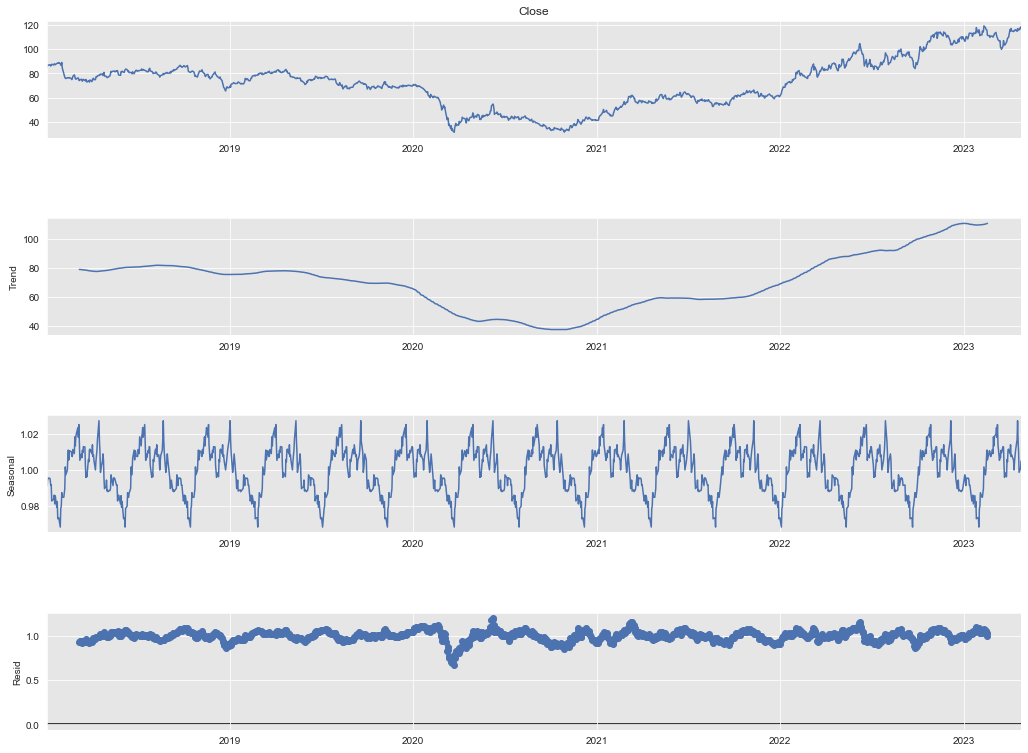

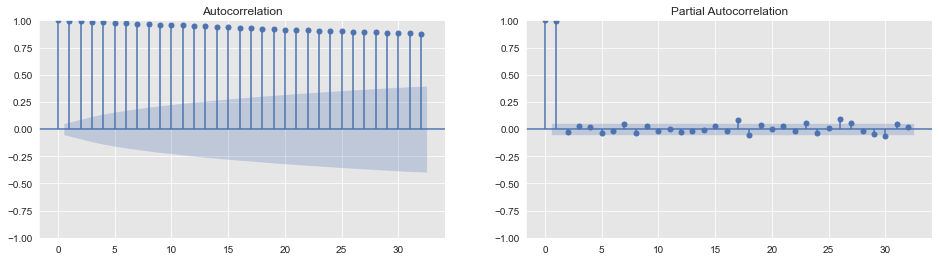

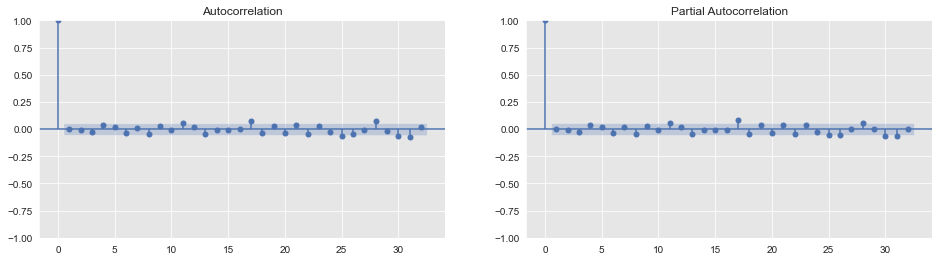

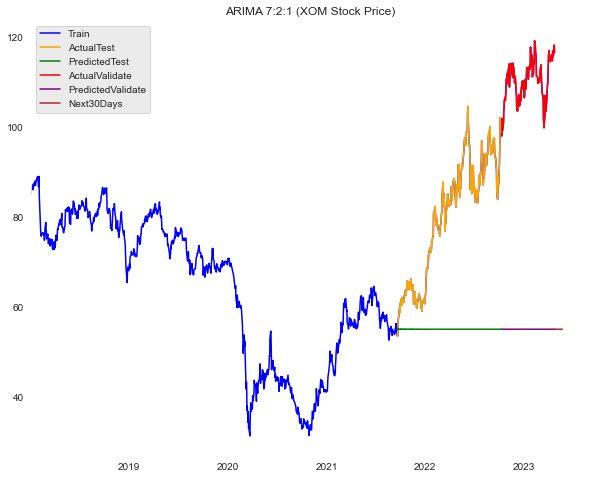

END===============================================
DATASET : CVX
START===============================================
Dataset size 1337 

Train size :  935
Test size :  267
Valid size :  135


c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


ADF Statistic: -12.819993
p-value: 0.000000
Evaluate ----------------- 
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3998.499, Time=0.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4032.684, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4023.730, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4025.056, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4030.917, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4023.543, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4023.789, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=4025.936, Time=1.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4023.079, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4025.205, Time=0.60 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4025.602, Time=0.38 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=4001.519, Time=1.55 sec
 ARIMA(2,1,2)(0,0,0)[0]         

c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


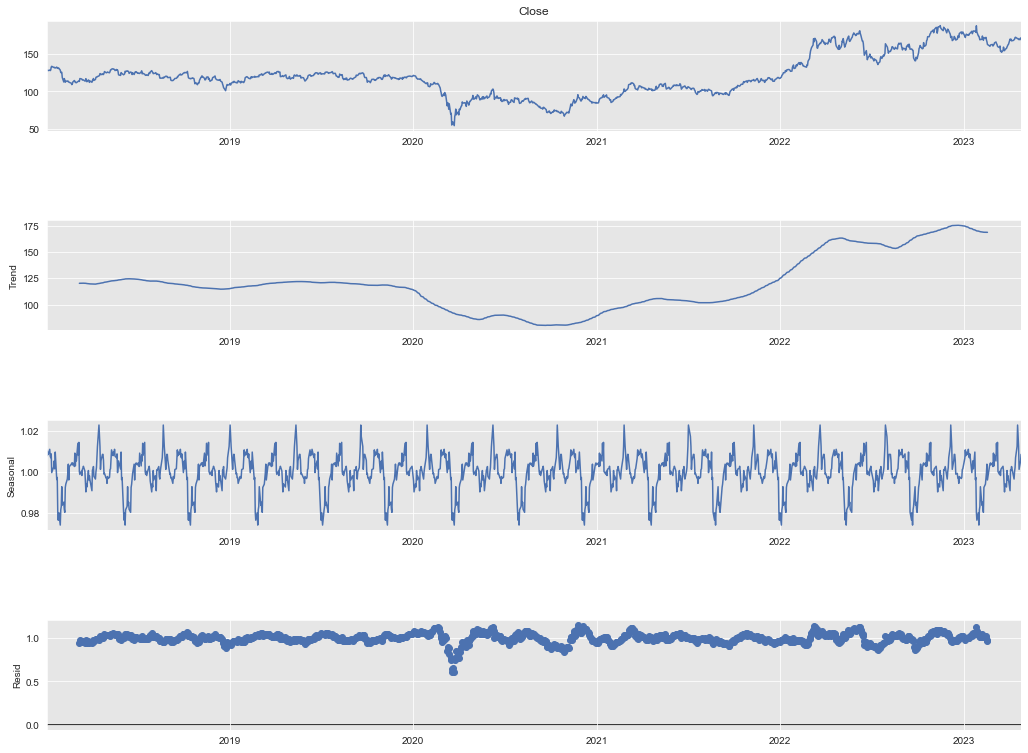

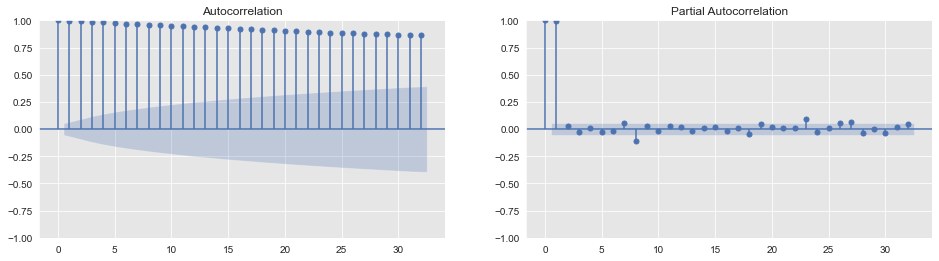

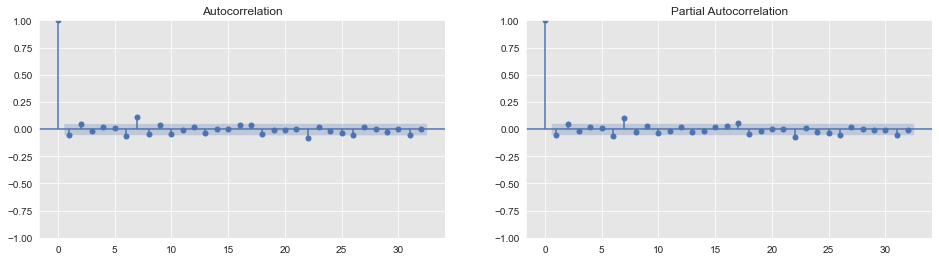

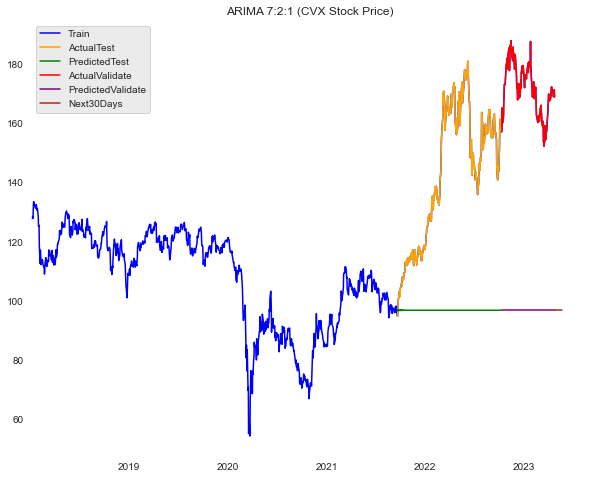

END===============================================
DATASET : VLO
START===============================================
Dataset size 1337 

Train size :  935
Test size :  267
Valid size :  135


c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


ADF Statistic: -37.671439
p-value: 0.000000
Evaluate ----------------- 
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3931.463, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3930.686, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3931.767, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3931.840, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3928.888, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3933.317, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.993 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  935
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1963.444
Date:                Sun, 18 Jun 2023   AIC                           3928.888
Time:                        14:54:21   BIC                           3933.728
Sample:          

c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


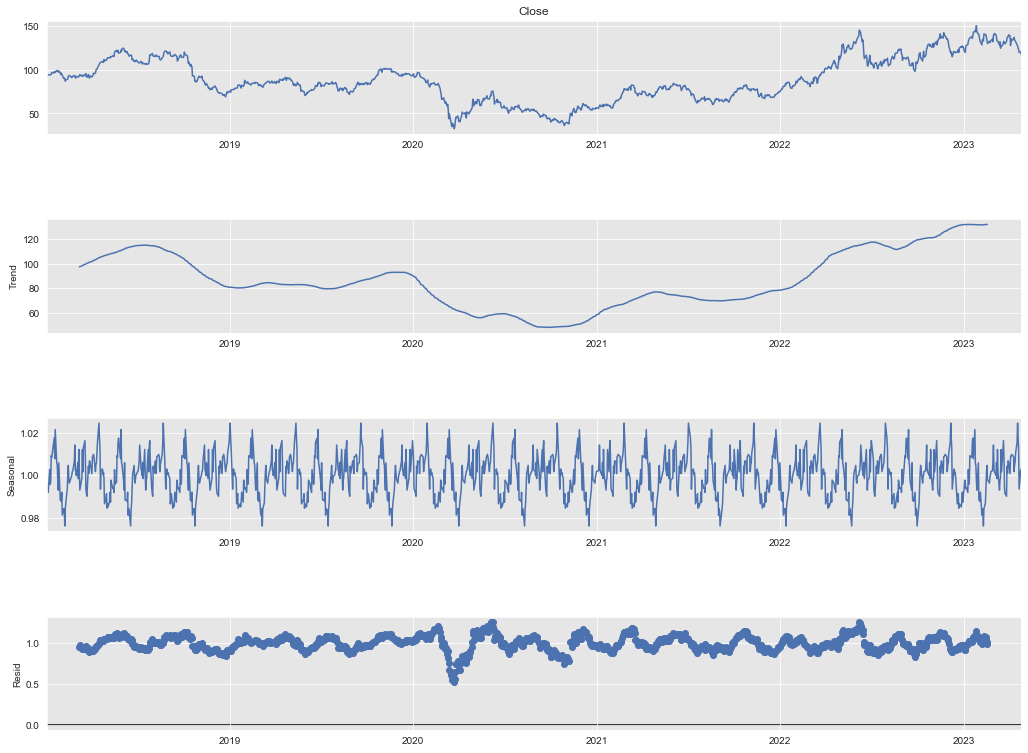

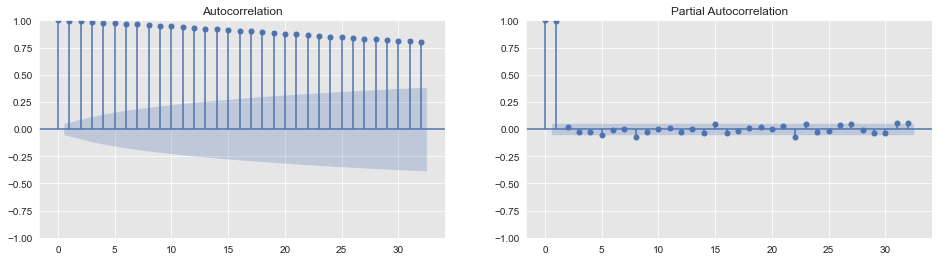

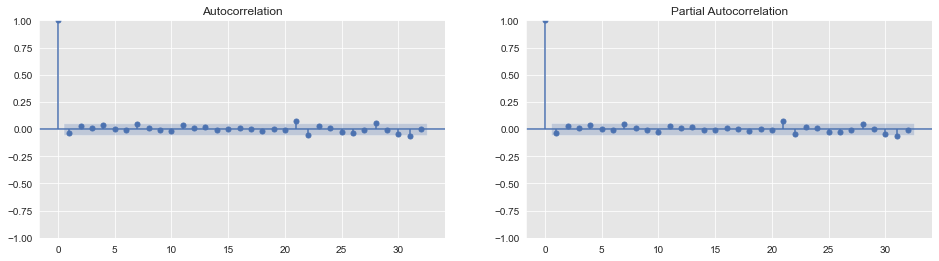

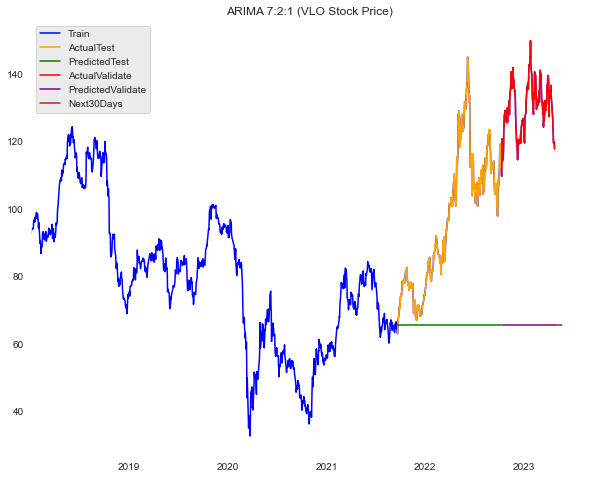

END===============================================


In [57]:
#apply class model aboe for 3 data set
#data set list string
# size plit 7-2-1
data_set = ['XOM','CVX','VLO']
for data in data_set : 
    print(f"DATASET : {data}")
    print("START===============================================")
   
    title = f'ARIMA 7:2:1 ({data} Stock Price)'
    data_path = os.path.join(DATA_FOLDER, f'{data}.csv')
    model = ARIMA_Model(data_path)
    model.split_data(0.2,0.1)
    model.info_data()

    model.decompose(model.df['Close'])
    model.plot_acf_pacf(model.df['Close'])
    df_diff = model.stationary(model.df['Close'])
    model.plot_acf_pacf(df_diff)
    model.adf_test(df_diff)
    
    
    # plot predict
    model.plot_data(title) # or df
 
    print("END===============================================")

DATASET : XOM
START===============================================
Dataset size 1337 

Train size :  802
Test size :  267
Valid size :  268


c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


ADF Statistic: -36.501831
p-value: 0.000000
Evaluate ----------------- 
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2495.705, Time=1.44 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2499.343, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2501.322, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2501.324, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2497.854, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2502.154, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2502.294, Time=0.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2495.691, Time=1.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2504.196, Time=0.39 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2499.106, Time=1.54 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2502.524, Time=2.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2504.889, Time=1.03 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=2504.037, Time=1.07 sec
 ARIMA(4,1,3)(0,0,0)[0] int

c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


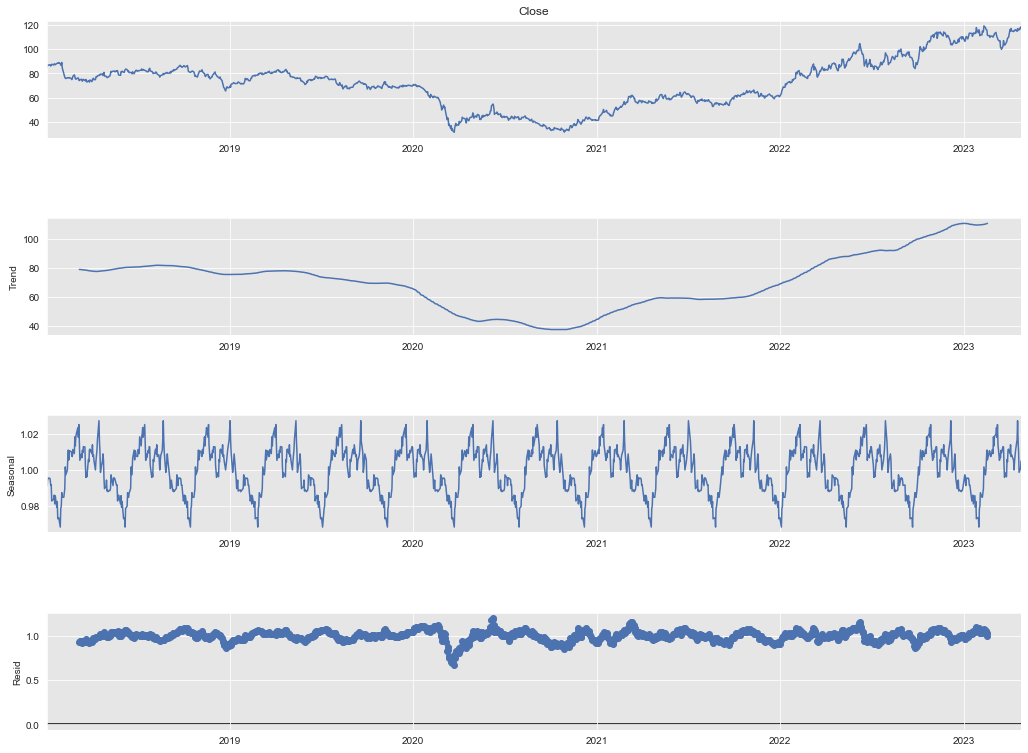

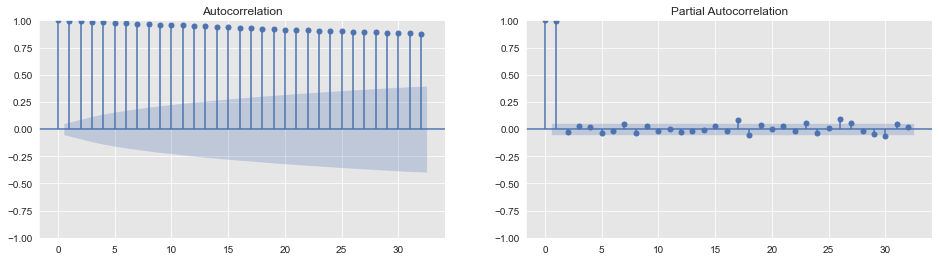

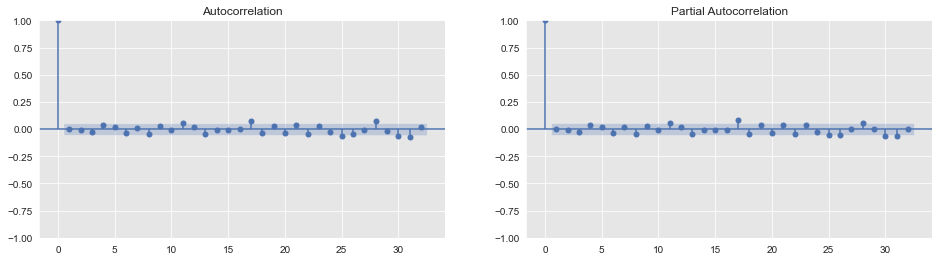

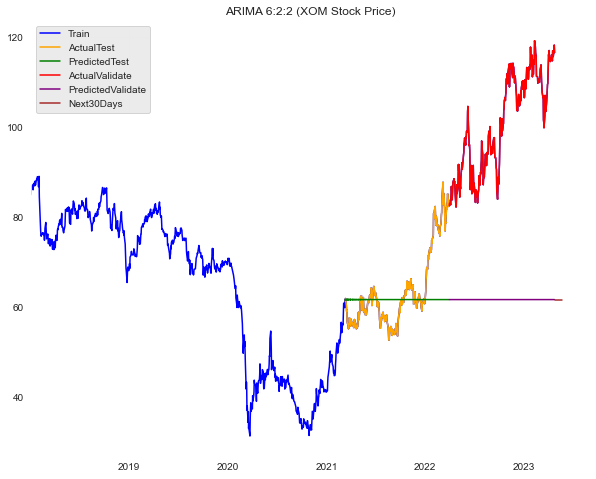

END===============================================
DATASET : CVX
START===============================================
Dataset size 1337 

Train size :  802
Test size :  267
Valid size :  268


c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


ADF Statistic: -12.819993
p-value: 0.000000
Evaluate ----------------- 
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3476.507, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3511.828, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3502.527, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3504.163, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3509.898, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3501.354, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3501.566, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3505.341, Time=0.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3505.330, Time=0.36 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3501.577, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3503.338, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3491.383, Time=0.52 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3480.298, Time=1.51 sec
 ARIMA(2,1,2)(0,0,0)[0]    

c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


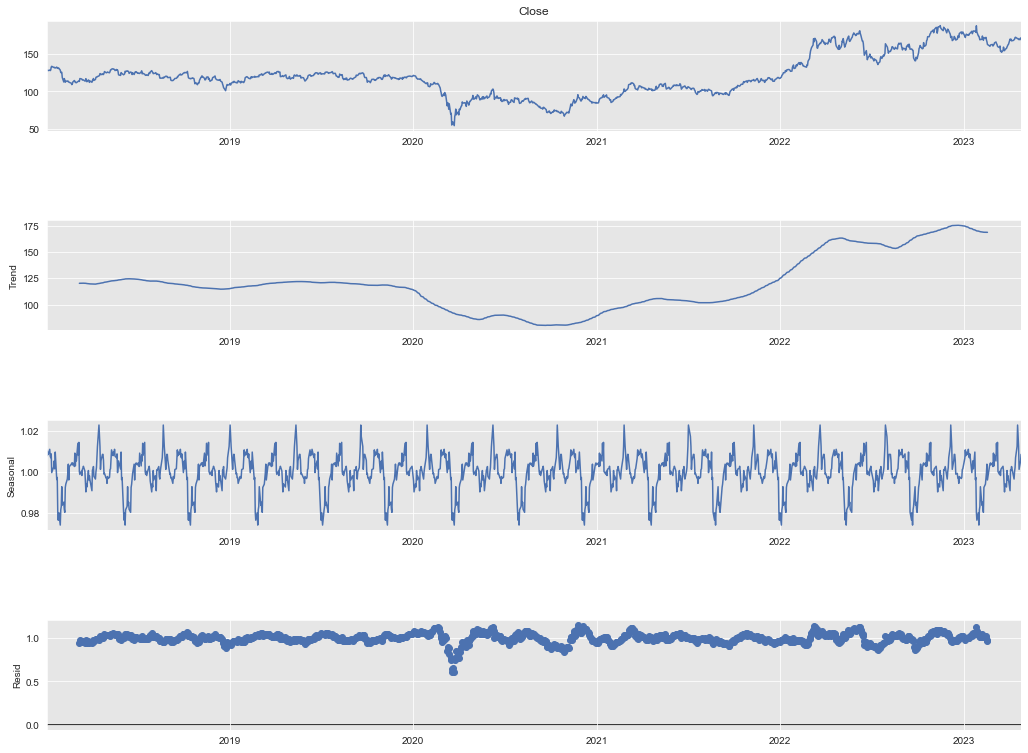

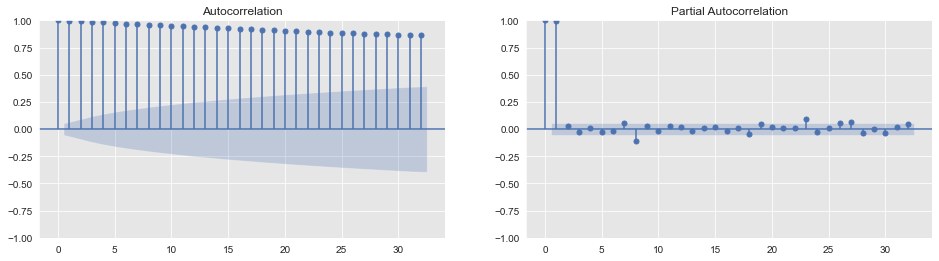

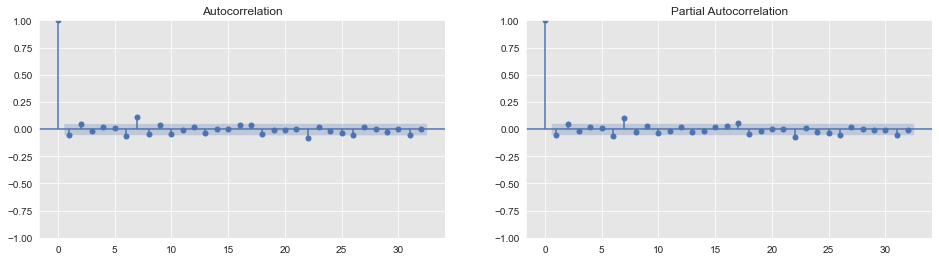

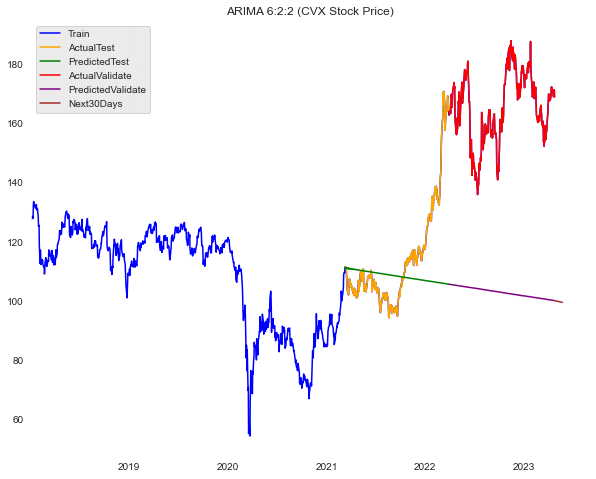

END===============================================
DATASET : VLO
START===============================================
Dataset size 1337 

Train size :  802
Test size :  267
Valid size :  268


c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


ADF Statistic: -37.671439
p-value: 0.000000
Evaluate ----------------- 
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3406.921, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3407.042, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3408.197, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3408.259, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3405.082, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3409.884, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.075 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  802
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1701.541
Date:                Sun, 18 Jun 2023   AIC                           3405.082
Time:                        14:58:34   BIC                           3409.768
Sample:          

c:\Users\Minh Cuong\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


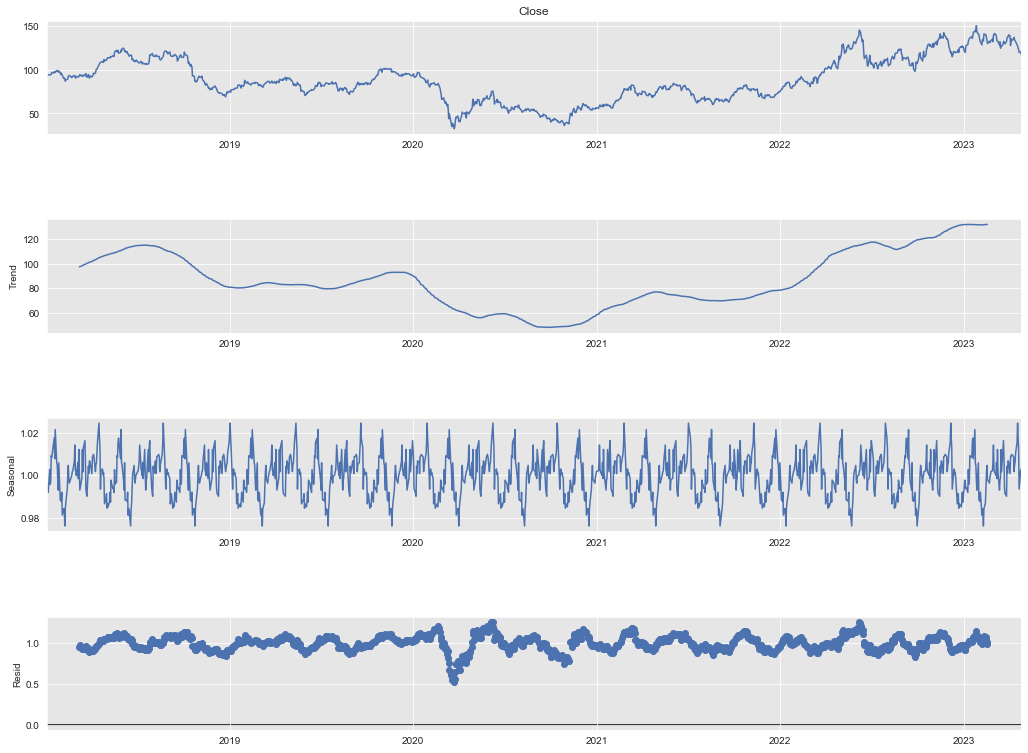

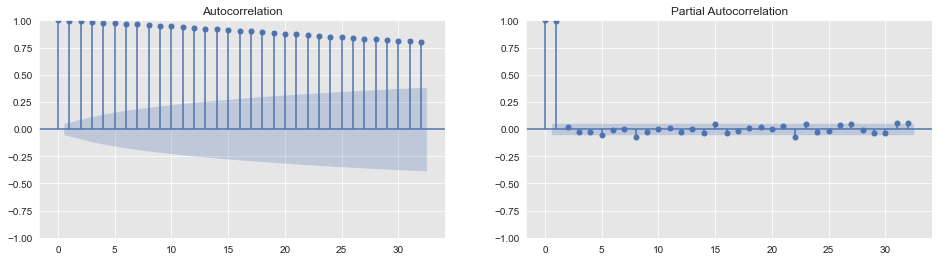

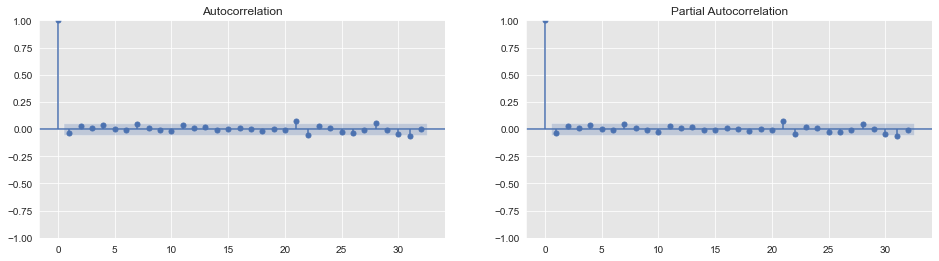

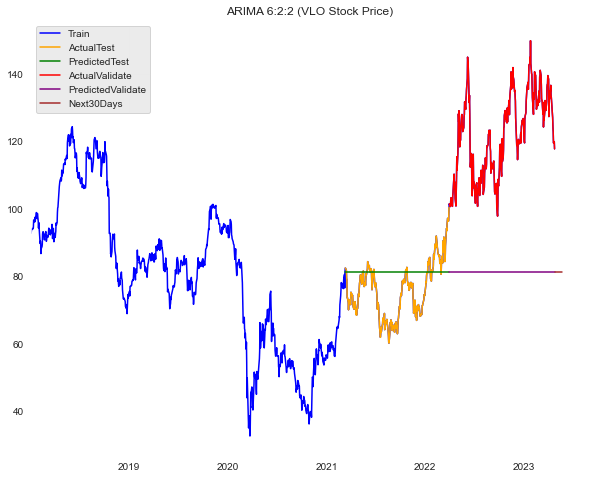

END===============================================


In [58]:
#apply class model aboe for 3 data set
#data set list string
# size plit 6-2-2
data_set = ['XOM','CVX','VLO']
for data in data_set : 
    print(f"DATASET : {data}")  
    print("START===============================================")
    

    title = f'ARIMA 6:2:2 ({data} Stock Price)'

    data_path = os.path.join(DATA_FOLDER, f'{data}.csv')
    model = ARIMA_Model(data_path)
    model.split_data(0.2,0.2)
    model.info_data()

    model.decompose(model.df['Close'])
    model.plot_acf_pacf(model.df['Close'])
    df_diff = model.stationary(model.df['Close'])
    model.plot_acf_pacf(df_diff)
    model.adf_test(df_diff)
    
    
    # plot predict
    model.plot_data(title) # or df
 
    print("END===============================================")